### 1. Data Loda

In [1]:
import pandas as pd
import numpy as np 

In [2]:
train_data = pd.read_pickle('./raw_data/train.pickle')
test_data = pd.read_pickle('./raw_data/test.pickle')

In [3]:
num_data = train_data.cust_ip_no.value_counts()
ip_list = []
for i in num_data.index:
    ip_list.append(str(i))
    
    
using_ip = []
for i, j in num_data.iteritems():
    if j >= 10079:
        using_ip.append(i)
        

In [4]:
# 총 28개의 ip 실험
print(using_ip)
print(len(using_ip))

[8187.0, 11784.0, 10580.0, 10515.0, 10468.0, 9366.0, 10630.0, 10683.0, 9365.0, 8938.0, 8923.0, 8902.0, 11654.0, 8879.0, 10554.0, 11707.0, 8860.0, 11837.0, 8511.0, 8257.0, 12413.0, 8258.0, 8259.0, 12243.0, 11983.0, 8768.0, 11857.0, 8182.0]
28


In [5]:
# ddos 이력이 있는 ip 8939 추가 
using_ip.extend([8939])
print(using_ip)

[8187.0, 11784.0, 10580.0, 10515.0, 10468.0, 9366.0, 10630.0, 10683.0, 9365.0, 8938.0, 8923.0, 8902.0, 11654.0, 8879.0, 10554.0, 11707.0, 8860.0, 11837.0, 8511.0, 8257.0, 12413.0, 8258.0, 8259.0, 12243.0, 11983.0, 8768.0, 11857.0, 8182.0, 8939]


In [6]:
train_df = train_data[train_data.cust_ip_no.isin(using_ip)]
test_df = test_data[test_data.cust_ip_no.isin(using_ip)] 

In [7]:
print(train_df[train_df.event == 1].cust_ip_no.unique())
print(test_df[test_df.event == 1].cust_ip_no.unique())

[8938. 9365. 8923. 8939. 8879.]
[8938. 8923. 8939.]


In [8]:
train_list = [] 
for i in using_ip:
    df = train_df[train_df.cust_ip_no == i]
    df.reset_index(drop=True, inplace=True) 
    train_list.append(df)
    

test_list = []
for i in using_ip:
    df = test_df[test_df.cust_ip_no == i]
    df.reset_index(drop=True, inplace=True)
    test_list.append(df)    

### 2. Data preprocessing :  create sequence data, remove gap data

In [9]:
from datetime import timedelta, datetime

# train data preprocessing
gap_dic = {}
for ip in range(len(train_list)):
    gap_list = []
    for data in range(len(train_list[ip])-1):
        gap = (datetime.strptime(str(train_list[ip].stamp_inserted[data+1]),'%Y%m%d%H%M%S')) - (datetime.strptime(str(train_list[ip].stamp_inserted[data]),'%Y%m%d%H%M%S'))
        if gap > timedelta(minutes=1):
            gap_list.append((data))
    gap_dic[train_list[ip].cust_ip_no[0]] = gap_list

    
for ip in gap_dic.keys():
    gap_list = []
    for i in gap_dic[ip] :
        gap_num = i - 5
        for j in range(6):
            gap_list.append(gap_num+j)
    gap_dic[ip] = gap_list

    
# test data preprocessing    
gap_dic_test = {}
for ip in range(len(test_list)):
    gap_list = []
    for data in range(len(test_list[ip])-1):
        gap = (datetime.strptime(str(test_list[ip].stamp_inserted[data+1]),'%Y%m%d%H%M%S')) - (datetime.strptime(str(test_list[ip].stamp_inserted[data]),'%Y%m%d%H%M%S'))
        if gap > timedelta(minutes=1):
            gap_list.append((data))
    gap_dic_test[test_list[ip].cust_ip_no[0]] = gap_list

    
for ip in gap_dic_test.keys():
    gap_list = []
    for i in gap_dic_test[ip] :
        gap_num = i -5
        for j in range(6):
            gap_list.append(gap_num+j)
    gap_dic_test[ip] = gap_list


In [46]:
# train data

from tqdm import tqdm
seq_time = 6
iv = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'proto_entropy', 'icmp_ratio', 'tcp_ratio', 'udp_ratio',
       'tcp_flags_entropy', 'domestic_ratio']

features = len(iv)

X_tr = []
y_tr = [] 



for j in tqdm(range(len(train_list))):
    tr_data = pd.DataFrame(columns=iv)
    tr_label = []
    
    ip = list(gap_dic.keys())[j]
    gap = gap_dic[ip]
    for i in range(len(train_list[j]) - seq_time):
        if i not in gap:
            input_x = train_list[j].iloc[i:i+seq_time,3:-1]
            input_x = input_x.diff().iloc[1:,:]
            label = train_list[j].iloc[i+seq_time-1, -1]
            ip_NO = train_list[j].iloc[i+seq_time-1, 2]
            time = train_list[j].iloc[i+seq_time-1, 0]

            
            tr_data = pd.concat([tr_data, input_x], axis=0)
            ip_label_set = (time, ip_NO, label)            
            tr_label.append(ip_label_set) 
            
    X_tr.append(tr_data) 
    y_tr.append(tr_label)     
    

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [04:11<00:00,  8.67s/it]


In [71]:
# test data

seq_time = 6
iv = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'proto_entropy', 'icmp_ratio', 'tcp_ratio', 'udp_ratio',
       'tcp_flags_entropy', 'domestic_ratio']

features = len(iv)

X_ts = []
y_ts = [] 


for j in tqdm(range(len(test_list))):
    ts_data = pd.DataFrame(columns=iv)
    ts_label = []
    ip = list(gap_dic_test.keys())[j]
    gap = gap_dic_test[ip]
    
    
    for i in range(len(test_list[j]) - seq_time):
        if i not in gap:
            input_x = test_list[j].iloc[i:i+seq_time,3:-1]
            input_x = input_x.diff().iloc[1:,:] 
            label = test_list[j].iloc[i+seq_time-1, -1]
            ip_NO = test_list[j].iloc[i+seq_time-1, 2]  
            time = test_list[j].iloc[i+seq_time-1, 0]
            
            ts_data = pd.concat([ts_data, input_x], axis=0)
            ip_label_set = (time, ip_NO, label)            
            ts_label.append(ip_label_set)         
        else: 
            pass
            
    X_ts.append(ts_data) 
    y_ts.append(ts_label) 
    

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [04:05<00:00,  8.47s/it]


In [47]:
# train
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_list = []


X_tr_ = pd.DataFrame(columns=iv)
for i in X_tr:
    scaler = StandardScaler()
    tmp_input = pd.DataFrame(scaler.fit_transform(i.values), columns=iv)
    scaler_list.append(scaler)
    X_tr_ = pd.concat([X_tr_, tmp_input], axis=0)

y_tr_ = []
for i in y_tr:
    y_tr_.extend(i)


 # data check
X_tr_ = X_tr_.values.reshape(-1, 5, 12) 
train_y_df = pd.DataFrame(y_tr_, columns=['time','ip','label'])

normal_idx = train_y_df[train_y_df.label==0].index
X_normal = X_tr_[normal_idx,]
y_normal = train_y_df[train_y_df.label==0]


ddos_idx = train_y_df[train_y_df.label==1].index
X_ddos = X_tr_[ddos_idx,]
y_ddos = train_y_df[train_y_df.label==1]

In [72]:
# test: data scaling
X_ts_ = pd.DataFrame(columns=iv)
for n, i in enumerate(X_ts):
    scaler = scaler_list[n]
    tmp_input = pd.DataFrame(scaler.transform(i.values), columns=iv)
    X_ts_ = pd.concat([X_ts_, tmp_input], axis=0)

    
    
y_ts_ = []
for i in y_ts:
    y_ts_.extend(i)
    
# test df
X_ts = X_ts_.values.reshape(-1, 5, 12) 
y_ts = pd.DataFrame(y_ts_, columns=['time','ip','label'])

### 3. CNN AE

In [91]:
from tensorflow.keras import Model, models, optimizers, utils, layers
from keras.layers import LSTM, Dense, Activation, Conv1D, Dropout, Conv1DTranspose, BatchNormalization
from keras.models import load_model
import keras.backend as K

adam = optimizers.Adam(lr=0.0001)
kernel_s = 3 
seq_time = 5

K.clear_session()
cnn_ae = models.Sequential([
    layers.Input(shape=(seq_time, features)),
    layers.Conv1D(filters=12, kernel_size=kernel_s, padding='same', strides=1),
    layers.BatchNormalization(),
    Activation('relu'),
    layers.Conv1D(filters=36, kernel_size=kernel_s, padding='same', strides=1),
    layers.BatchNormalization(), 
    Activation('tanh'),
    layers.Conv1D(filters=36, kernel_size=kernel_s, padding='same', strides=1),
    layers.Conv1DTranspose(filters=36, kernel_size=kernel_s, padding='same', strides=1),
    #layers.BatchNormalization(),
    Activation('relu'),
    layers.Conv1DTranspose(filters=36, kernel_size=kernel_s, padding='same', strides=1),
    #layers.BatchNormalization(),
    Activation('relu'),
    layers.Conv1DTranspose(filters=12, kernel_size=kernel_s, padding='same'),
]) 

cnn_ae.compile(optimizer=adam, loss='mse') 

In [92]:
hist = cnn_ae.fit(X_normal, X_normal, epochs=40, validation_split=0.1, batch_size=128, shuffle=True, verbose=2)

Epoch 1/40
2052/2052 - 5s - loss: 0.4772 - val_loss: 0.3684
Epoch 2/40
2052/2052 - 4s - loss: 0.2929 - val_loss: 0.2892
Epoch 3/40
2052/2052 - 4s - loss: 0.2289 - val_loss: 0.2290
Epoch 4/40
2052/2052 - 4s - loss: 0.1809 - val_loss: 0.1827
Epoch 5/40
2052/2052 - 4s - loss: 0.1444 - val_loss: 0.1474
Epoch 6/40
2052/2052 - 4s - loss: 0.1160 - val_loss: 0.1193
Epoch 7/40
2052/2052 - 4s - loss: 0.0948 - val_loss: 0.1009
Epoch 8/40
2052/2052 - 4s - loss: 0.0798 - val_loss: 0.0852
Epoch 9/40
2052/2052 - 4s - loss: 0.0685 - val_loss: 0.0751
Epoch 10/40
2052/2052 - 4s - loss: 0.0603 - val_loss: 0.0687
Epoch 11/40
2052/2052 - 4s - loss: 0.0543 - val_loss: 0.0626
Epoch 12/40
2052/2052 - 4s - loss: 0.0492 - val_loss: 0.0581
Epoch 13/40
2052/2052 - 4s - loss: 0.0454 - val_loss: 0.0549
Epoch 14/40
2052/2052 - 4s - loss: 0.0417 - val_loss: 0.0501
Epoch 15/40
2052/2052 - 4s - loss: 0.0390 - val_loss: 0.0487
Epoch 16/40
2052/2052 - 4s - loss: 0.0364 - val_loss: 0.0443
Epoch 17/40
2052/2052 - 4s - loss

In [93]:
from plotly.offline import plot, iplot 
import plotly.graph_objects as go

loss = hist.history['loss'] 
val_loss = hist.history['val_loss'] 

fig = go.Figure()
fig.add_trace(go.Scatter(y=loss, mode='lines', name='loss')) 
fig.add_trace(go.Scatter(y=val_loss, mode='lines', name='val_loss'))
fig.update_layout(height=400, width=600, title='loss of CAE')
fig.show() 

In [100]:
# try detecting with train set and setting the optimal threshold

pred_x = cnn_ae.predict(X_normal).reshape(X_normal.shape[0],-1)
real = X_normal.reshape(X_normal.shape[0], -1) 
log_mse = np.log(np.mean(np.power(real-pred_x, 2), axis=1)) 
mse = np.mean(np.power(real-pred_x, 2), axis=1)
train_df_error = pd.DataFrame({'time':y_normal.time, 'recon_size':mse, 'IP':y_normal.ip, 'reconstruction_error':log_mse, 'Label':y_normal.label})


thr = train_df_error[['reconstruction_error','Label']].describe()
error = sorted(train_df_error.reconstruction_error.values, reverse=True)

up_to_99_5 = int(round(len(error) * 0.003,0)) 
up_to_99_5

threshold = error[up_to_99_5]
max_error = error[0]
print(thr)
print(threshold) 

       reconstruction_error     Label
count         291779.000000  291779.0
mean              -5.276535       0.0
std                0.678930       0.0
min               -6.199510       0.0
25%               -5.688544       0.0
50%               -5.464030       0.0
75%               -5.100245       0.0
max                4.420908       0.0
-1.1660410206052583


In [101]:
# Model evaluation (batch 128, epoch 40) with upper 0.5%
from sklearn.metrics import confusion_matrix, classification_report

pred_x = cnn_ae.predict(X_ts).reshape(X_ts.shape[0],-1)
real = X_ts.reshape(X_ts.shape[0], -1)
log_mse = np.log(np.mean(np.power(real-pred_x, 2), axis=1))
mse = np.mean(np.power(real-pred_x, 2), axis=1)
test_df_error = pd.DataFrame({'time':y_ts.time, 'reconstruction_error':log_mse, 'recon_size':mse, 'Label':y_ts.label, 'IP':y_ts.ip})



pred_y = [1 if e > threshold else 0 for e in test_df_error['reconstruction_error'].values]
confusion_m = confusion_matrix(y_ts.label, pred_y)
classification = classification_report(y_ts.label, pred_y)
test_df_error['predicted_y'] = pred_y
print(confusion_m)
print(classification)


[[289330   1601]
 [     0     78]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    290931
         1.0       0.05      1.00      0.09        78

    accuracy                           0.99    291009
   macro avg       0.52      1.00      0.54    291009
weighted avg       1.00      0.99      1.00    291009



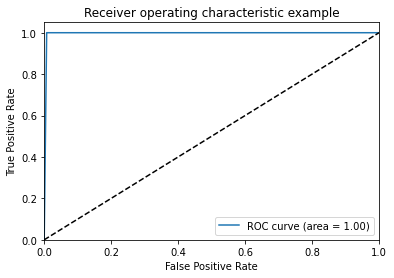

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

fpr, tpr, thresholds = roc_curve(test_df_error.Label, pred_y)
roc_auc = auc(fpr, tpr)

plt.figure() 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right") 
plt.show()

In [103]:
# # comparing the reconstruction distribution 
# import plotly.figure_factory as ff
# from plotly.offline import plot, iplot 

# test_ddos = test_df_error[test_df_error.Label ==1 ]
# test_normal = test_df_error[test_df_error.Label ==0 ]
# data = [train_df_error.reconstruction_error, test_ddos.reconstruction_error, test_normal.reconstruction_error]
# group = ['train normal', 'test ddos', 'test normal'] 
# fig = ff.create_distplot(data, group, bin_size=[.2,.2,.2])
# fig.update_layout(title='Reconstruction distribution') 
# fig.show() 